In [1]:
# !pip install mlxtend

# Model stacking

Le stacking est une technique d'apprentissage d'ensembliste permettant de combiner plusieurs modèles de classification via un méta-classificateur. 
Les modèles de classification individuels sont entrainés sur l'ensemble du jeu d'entrainement ; 
ensuite, le métaclassificateur est entrainé en fonction des résultats - *les métacaractéristiques* - des modèles de classification individuels inclus dans l'ensemble. 
Le métaclassificateur peut être entrainés soit sur les labels des classes prédites, soit sur les probabilités prédites issues de l'ensemble (predict_proba).

<img src="stacking/stackingclassification_overview.png">

L'algorithme peut se décrire sous cette forme : 
<img src="stacking/stacking_algorithm.png">

**!!! Important !!!**

Il faut noter que ce type de stacking est *susceptible d'overfitter le jeu de données* en raison d'une fuite d'information (**information leakage**). Le **StackingCVClassifier** de la librairie mlxtend pertmet de résoudre ce problème car n'infère pas les prédictions pour le classificateur de 2e niveau (métaclassifieur) à partir des mêmes données que celles utilisées pour la entrainer les classificateurs de niveau 1. Il est recommandé de toujours utiliser cette technique de stacking à la place de celle présenté plus haut.  

<img src="stacking/stacking_cv_classification_overview.png">
<img src="stacking/stacking_cv_algorithm.png">

## Chargement du jeu de données

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris, load_breast_cancer
random_seed = 20

Nous allons illustrer ce TP sur la base d'un exemple simple de classification à 2 classes, à l'aide du jeu de données breast_cancer.

In [3]:
cancer = load_breast_cancer()
df = pd.DataFrame(np.c_[cancer['data'], cancer['target']],
                  columns= np.append(cancer['feature_names'], ['target']))

In [4]:
df.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst symmetry  worst fractal dimension  target  
0          0.4601                  0.11890     0.0  
1          0.2750                  0.08902     0.0  
2          0.3613                  0.08758     0.0  
3          0.6638                  0.17300     0.0  
4          0.2364                  0.07678     0.0  

[5 rows x 31 columns]

In [5]:
df.shape

(569, 31)

In [6]:
X, y = df.iloc[:,0:30], df.iloc[:,30]

Séparons notre jeu de données en deux jeux Train/Test.

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 45 )

In [42]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((455, 30), (455,), (114, 30), (114,))

## Classifieurs "Base Learners"

La première étape consiste à entrainer un jeu de plusieurs classifieurs que nous désignerons comme étant des classifieurs de niveau 1 ou "classifieurs de base". 

In [43]:
#Base Learners
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,  AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=random_seed)
knn_clf = KNeighborsClassifier(n_neighbors=2) 
svc_clf = SVC(C=100000.0, kernel='rbf', random_state=random_seed)


# Autres classifieurs avec lesquels essayer 

#et_clf = ExtraTreesClassifier(n_estimators=5, random_state=random_seed)
#rg_clf = RidgeClassifier(alpha=0.1, random_state=random_seed)
#lr_clf = LogisticRegression(C=20000, penalty='l2', random_state=random_seed)
#rf_clf = RandomForestClassifier(n_estimators=10, random_state=random_seed)
#adab_clf = AdaBoostClassifier(n_estimators=100)

## Meta Classifier 
Nous allons ensuite créer un méta-classifieur qui sera le second étage du processus de stacking. 

In [44]:
from mlxtend.classifier import StackingCVClassifier
from sklearn import model_selection
import warnings

warnings.simplefilter('ignore')


# meta classifier
lr = LogisticRegression(random_state=random_seed) 

# stacking classifier 
sclf = StackingCVClassifier(classifiers=[dt_clf, knn_clf, svc_clf], meta_classifier=lr, random_state=0)


classifier_array = [dt_clf, knn_clf, svc_clf, sclf]
labels = [clf.__class__.__name__ for clf in classifier_array]
acc_list = []
var_list = []
for clf, label in zip(classifier_array, labels):
    cv_scores = model_selection.cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (cv_scores.mean(), cv_scores.std(), label))
    acc_list.append(np.round(cv_scores.mean(),4))
    var_list.append(np.round(cv_scores.std(),4))
    #print("Accuracy: {} (+/- {}) [{}]".format(np.round(scores.mean(),4), np.round(scores.std(),4), label))

Accuracy: 0.9362 (+/- 0.0226) [DecisionTreeClassifier]
Accuracy: 0.9099 (+/- 0.0115) [KNeighborsClassifier]
Accuracy: 0.6264 (+/- 0.0020) [SVC]
Accuracy: 0.9385 (+/- 0.0172) [StackingCVClassifier]


On constate une amélioration des performances sur le jeu d'entrainement ! Il propose la meilleure accuracy et la variance sur l'ensemble des folds est plus faible qu'avec 2 des trois classifieurs de base. 

Bien joué !

## Frontières de décision 
Nous allons à présent visualiser la frontière de décision pour les différents base classifiers.

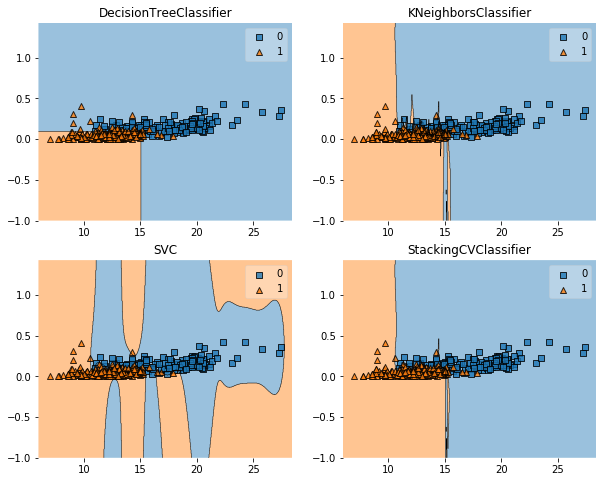

In [32]:
# Now plot the decision regions with only two features

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip([dt_clf, knn_clf, svc_clf, sclf], 
                         ['DecisionTreeClassifier', 
                          'KNeighborsClassifier', 
                          'SVC',
                          'StackingCVClassifier'],
                          itertools.product([0, 1], repeat=2)):
   
    clf.fit(X_train[['mean radius','mean concavity']], y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X_train[['mean radius','mean concavity']].values, 
                                y_train.values.astype(np.integer),
                                clf=clf)
    plt.title(lab)


Il est assez intéressant de comparer les frontières de décisions prises par chacun des classifieurs de base et la frontière finale obtenue par stacking. 

Que constatez-vous? 
Essayer de visualiser la frontière de décision pour d'autres couples de variables. 


## Entrainement du classifieur et prédiction sur le jeu de test

In [33]:
sclf.fit(X_train, y_train)
y_predict = sclf.predict(X_test)

In [34]:
from sklearn.metrics import accuracy_score

test_acc = accuracy_score(y_test, y_predict)
print("Accuracy obtained by the stacking classifier: %0.4f" % (test_acc))

Accuracy obtained by the stacking classifier: 0.9123


Comparons la performance de chaque classifieur de base et celle de notre méta-classifieur obtenu par stacking.

In [45]:
for clf, lab, grd in zip([dt_clf, knn_clf, svc_clf, sclf], 
                         ['DecisionTreeClassifier', 
                          'KNeighborsClassifier', 
                          'SVC',
                          'StackingCVClassifier'],
                          itertools.product([0, 1], repeat=2)):
   
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_predict)
    print("Accuracy: %0.4f [%s]" % (test_acc, lab))

Accuracy: 0.9123 [DecisionTreeClassifier]
Accuracy: 0.8947 [KNeighborsClassifier]
Accuracy: 0.6316 [SVC]
Accuracy: 0.9123 [StackingCVClassifier]


Le stacking des trois classifieurs a permis d'obtenir une meilleure performance sur le jeu d'entraiement et sur le jeu de test. Sur cet exemple simple, notre jeu de données de test ne contient pas beaucoup d'échantillons, la différence n'est pas si flagrante sur le jeu de test, mais elle était bien visible sur les jeu d'entrainement. A vous de reprendre cette méthodologie et de l'appliquer sur un problème plus complexe ! 

Bon stacking ! 